<a href="https://colab.research.google.com/github/malfii/airbnb_investment/blob/main/03_modeling_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling listing prices

In this notebook, we will use different approaches to model listing price. The target variable in this notebook is the `price` column in our cleaned data.

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# xgboost
import xgboost as xgb

#Bayesian optimizer
!pip install scikit-optimize
from skopt import BayesSearchCV

# tensorflow/keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.1 MB/s eta 0:00:00


In [3]:
#df = pd.read_csv('./../data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df = pd.read_csv('https://raw.githubusercontent.com/malfii/airbnb_investment/main/data/austin_listings_clean.csv').drop(columns=['occupancy_rate'])
df.head(5)

,bedrooms,beds,bath,zipcode,host_is_superhost,review_scores_rating,time_quarter,has_pool,is_petfriendly,has_workspace,has_freeparking,has_gym,home_price_aprx,price
0,1,2,1.0,78702,1,4.84,Q4,0,0,0,0,0,613000,101.000000
1,0,1,1.0,78704,0,4.97,Q4,0,0,1,0,0,802000,91.666667
2,1,2,1.0,78704,1,4.97,Q4,0,0,1,1,0,802000,159.000000
3,1,1,1.0,78741,0,4.56,Q4,0,1,0,0,0,397000,48.000000
4,2,2,2.0,78702,1,5.00,Q4,0,0,1,0,0,613000,123.000000


## Correlation between different features

<ipython-input-8-afb412dfb271>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = round(df.corr(), 2)


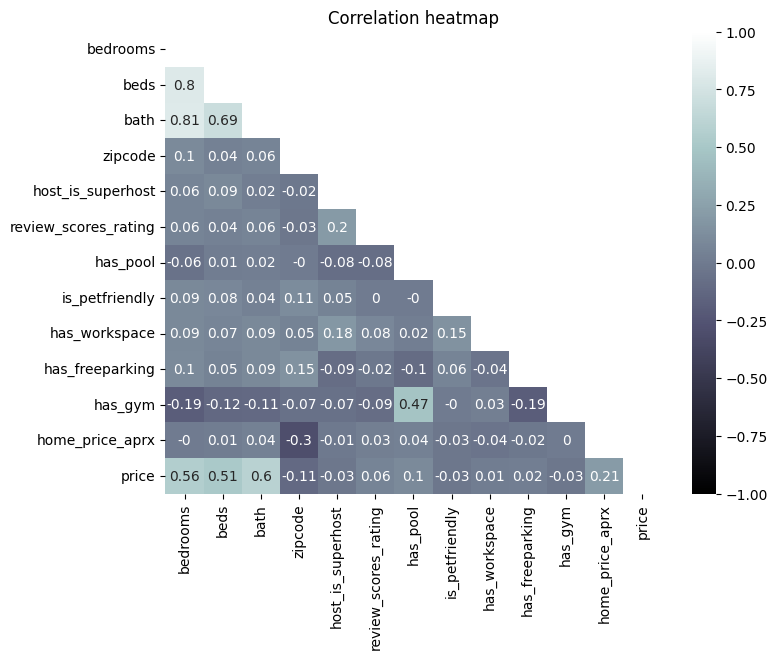

In [8]:
# plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
corr = round(df.corr(), 2)
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, annot=True, cmap='bone',
            vmin = -1, vmax=1)
plt.title('Correlation heatmap');



From this graph, we can see the listing price shows the highest correlation with bedrooms, baths,and homeprice. Note that categorical features like the time of the listing is not considered here.

Also, looking at the correlation matrix heatmap, we can say features like beds, bedrooms, and bath are correlated to each other. Another interesting observation is the fact that the houses that have pool are more likely to have gym as well.

## Null model

We will start our analysis with the null model. For this, the average listing price will be considered as our prediction.

In [9]:
# create a dataframe for the null model
df_null_model = df.copy()
X = df_null_model.drop(columns=['price'])
y = df_null_model['price']
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)
pred = y_train.mean()
print(f'predicted price for the null model: ${int(pred)}/night')

predicted price for the null model: $246/night


In [10]:
preds_train = pred*np.ones(len(y_train))
preds_test = pred*np.ones(len(y_test))
print(f'Train data R2 = {r2_score(y_train, preds_train)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {r2_score(y_test, preds_test)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.0
Train data MAE ($) = 152
Test data R2 = -0.0002555833763804305
Test data MAE ($) = 154


__Highlights__:

## Simple linear regression

We will start our modeling by building a simple linear regression model with a few features that seem to have the highest impact on listing price. The featues are `bedrooms`, `beds`, `bath`, `has_pool`, `time_quarter`, and `home_price_aprx`.

In [11]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_simple_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_simple_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_pipeline.predict(X_train)
preds_test = lr_simple_pipeline.predict(X_test)

In [12]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4398
Train data MAE ($) = 110
Test data R2 = 0.4288
Test data MAE ($) = 111


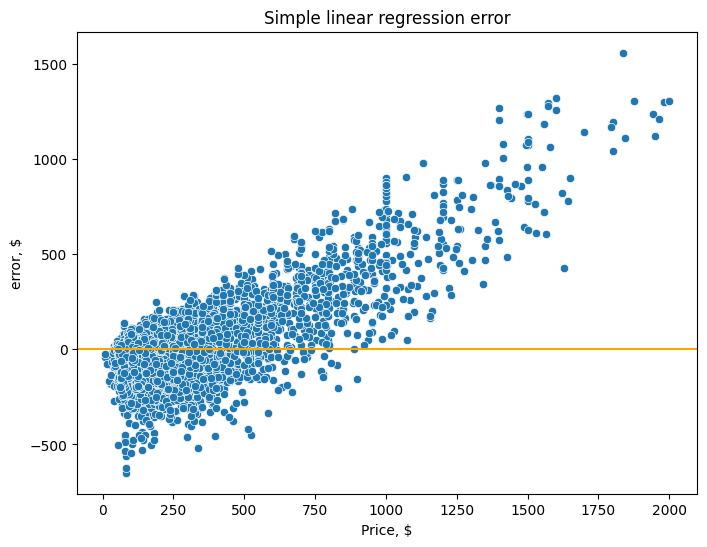

In [13]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Simple linear regression error')
plt.axhline(0, color='orange');

As we can see, the model shows issues modeling the listing prices. Let us see if adding some polynomial terms could help improce the linear model performance.  

In [14]:
X = df[['bedrooms', 'beds', 'bath', 'has_pool', 'time_quarter', 'home_price_aprx']]
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_simple_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2)), # polynomial feature, quadratic
    ('lr', LinearRegression())]
)

# fit the model
lr_simple_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_simple_poly_pipeline.predict(X_train)
preds_test = lr_simple_poly_pipeline.predict(X_test)

# quadratic and first degree interaction terms created
print('New features used in our model:')
lr_simple_poly_pipeline.named_steps['poly'].get_feature_names_out([
            'time_quarter_Q2', 'time_quarter_Q3',
            'time_quarter_Q4', 'bedrooms',
            'beds', 'bath', 'has_pool','home_price_aprx'])


New features used in our model:


array(['1', 'time_quarter_Q2', 'time_quarter_Q3', 'time_quarter_Q4',
       'bedrooms', 'beds', 'bath', 'has_pool', 'home_price_aprx',
       'time_quarter_Q2^2', 'time_quarter_Q2 time_quarter_Q3',
       'time_quarter_Q2 time_quarter_Q4', 'time_quarter_Q2 bedrooms',
       'time_quarter_Q2 beds', 'time_quarter_Q2 bath',
       'time_quarter_Q2 has_pool', 'time_quarter_Q2 home_price_aprx',
       'time_quarter_Q3^2', 'time_quarter_Q3 time_quarter_Q4',
       'time_quarter_Q3 bedrooms', 'time_quarter_Q3 beds',
       'time_quarter_Q3 bath', 'time_quarter_Q3 has_pool',
       'time_quarter_Q3 home_price_aprx', 'time_quarter_Q4^2',
       'time_quarter_Q4 bedrooms', 'time_quarter_Q4 beds',
       'time_quarter_Q4 bath', 'time_quarter_Q4 has_pool',
       'time_quarter_Q4 home_price_aprx', 'bedrooms^2', 'bedrooms beds',
       'bedrooms bath', 'bedrooms has_pool', 'bedrooms home_price_aprx',
       'beds^2', 'beds bath', 'beds has_pool', 'beds home_price_aprx',
       'bath^2', 'bath has_p

In [15]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.452
Train data MAE ($) = 107
Test data R2 = 0.4342
Test data MAE ($) = 110


We can see using polynomial features has slightly improved the performance of our linear regression.

__Highlights:__
- By using some of the most important features and interaction terms in linear regression, we can achieve an R2 of 0.47.

## Linear regression (with all features)

In  this case, we will use a simple linear regression model to predict the house price. Note that there are multiple categorical features (zipcode and time of the listing) that needs to be onehot encoded. We will use a pipeline to chain multiple operations.

In [16]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)



In [17]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4716
Train data MAE ($) = 107
Test data R2 = 0.4598
Test data MAE ($) = 110


As we can see, the model is performing just ok. Let us take a look at the errors to see where we are standing.

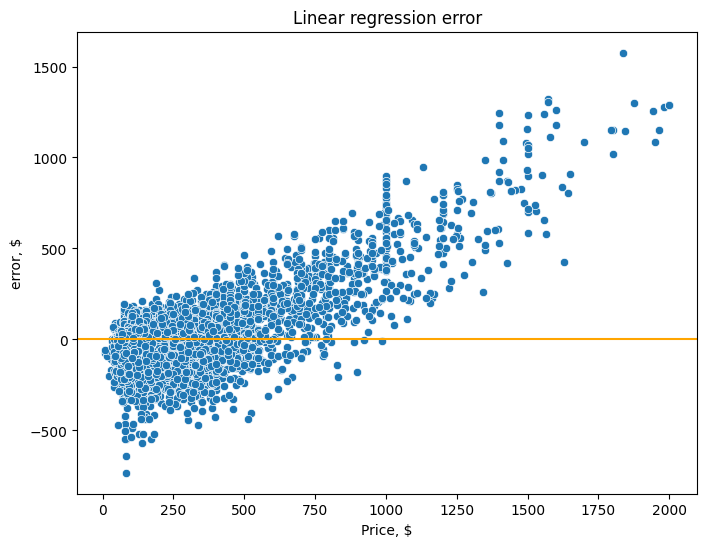

In [18]:
error = y_test - preds_test
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=error)
plt.xlabel('Price, $')
plt.ylabel('error, $')
plt.title('Linear regression error')
plt.axhline(0, color='orange');

We can see that for higher prices the error becomes larger. We will try to see if we can help with this issue by doing a log tranform of the price variable but before that, let us take a look at the coefficients of the linear regression.

In [19]:
pd.DataFrame(zip(lr_pipeline.named_steps['ohe_cols'].get_feature_names_out(),lr_pipeline.named_steps['lr'].coef_ ), columns=['feature', 'coef'])

,feature,coef
0,ohe_zip__zipcode_78702,-4.802767e+12
1,ohe_zip__zipcode_78703,1.510039e+13
2,ohe_zip__zipcode_78704,3.488742e+12
3,ohe_zip__zipcode_78705,-8.616935e+12
4,ohe_zip__zipcode_78717,-8.420294e+11
5,ohe_zip__zipcode_78719,-1.762098e+12
6,ohe_zip__zipcode_78721,-5.520181e+12
7,ohe_zip__zipcode_78722,-2.130443e+12
8,ohe_zip__zipcode_78723,-4.932200e+12
9,ohe_zip__zipcode_78724,-4.347306e+12


As we can see, the coeficients for the one hot encoded features realated to the zip code take very large numbers. This could be due to the fact that some zip codes will have very sparse data and it gives the column a strange structure that could impact the coefficients of linear regression and how linear regression performs. Let build another linear regression model without any zipcode data.

In [20]:
X = df.drop(columns=['price', 'zipcode'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
#        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('lr', LinearRegression())]
)

# fit the model
lr_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_pipeline.predict(X_train)
preds_test = lr_pipeline.predict(X_test)

In [21]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.4486
Train data MAE ($) = 109
Test data R2 = 0.4393
Test data MAE ($) = 111


We can see that excluding zipcode data slightly decreases our R2 score but the effect is not that much.

__Highlights:__
- Linear regression with all features included shows an average performance (R2 = 0.46)
- Adding zipcode feature makes the linear model coefficients to behave strangely due to the sparse nature of the zipcode regions. Zipcode related coefficients take very high values in our linear regression model.
- Removing zipcode from our linear model does not impact R2 noticably (R2 = 0.43).

## Linear regression with polynomial features (Ridge/LASSO)

We will now build a linear regression model that uses most of the original features and polynomial features as well.

In [22]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lr_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('lr', LinearRegression())]
)

# fit the model
lr_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = lr_poly_pipeline.predict(X_train)
preds_test = lr_poly_pipeline.predict(X_test)



In [23]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5612
Train data MAE ($) = 94
Test data R2 = -9.739320984926727e+19
Test data MAE ($) = 38164241729


As expected, this model shows tremendous amount of overfitting. Let us see if we can get better results buy regularizing the model. We will start with gridsearching over different ridge regularization alphas.

In [24]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
ridge_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('ridge', Ridge())]
)

# gridsearch object
gs_ridge_poly_pipeline = GridSearchCV(ridge_poly_pipeline,
                                     param_grid={'ridge__alpha': np.logspace(2, 4, 25)},
                                      verbose = 2,
                                      cv =3,
                                      n_jobs=-1
                                     )

# fit the model
gs_ridge_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_ridge_poly_pipeline.predict(X_train)
preds_test = gs_ridge_poly_pipeline.predict(X_test)

# best alpha
print(gs_ridge_poly_pipeline.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'ridge__alpha': 1778.2794100389228}


In [25]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5586
Train data MAE ($) = 94
Test data R2 = 0.5194
Test data MAE ($) = 98


We see using ridge helps with the high variance considerably. We will also see if LASSO provides any better results.

In [26]:
X = df.drop(columns=['price'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# column transformer to one hot encode categorical features
ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
onehot_cat = ColumnTransformer(
    transformers=[
        ('ohe_zip', ohe, ['zipcode']),
        ('ohe_time', ohe, ['time_quarter'])
    ], remainder='passthrough')
# create pipeline
lasso_poly_pipeline = Pipeline([
    ('ohe_cols', onehot_cat), # column transformer for cat features
    ('ss', StandardScaler()), # standard scaler
    ('poly', PolynomialFeatures(degree=2, interaction_only=False)),
    ('lasso', Lasso())]
)

# gridsearch object
gs_lasso_poly_pipeline = GridSearchCV(lasso_poly_pipeline,
                                     param_grid={'lasso__alpha': np.logspace(-1, 1, 25)},
                                      verbose = 3,
                                      cv =3,
                                      n_jobs=-1
                                     )

# fit the model
gs_lasso_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_lasso_poly_pipeline.predict(X_train)
preds_test = gs_lasso_poly_pipeline.predict(X_test)

# best alpha
print(gs_lasso_poly_pipeline.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
{'lasso__alpha': 0.5623413251903491}


In [27]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5549
Train data MAE ($) = 94
Test data R2 = 0.5205
Test data MAE ($) = 98


LASSO shows a performance similar to that of ridge but takes longer to run.

Before wrapping up this section, we will dig a little more into the error terms to see if we can get some information about how error is distributed and what contributes more to our error.

In [28]:
# create a new dataframe for error analysis
df_error = df.copy()
# assign predictions to train and test data
df_error['is_train'] = 1
df_error.loc[X_test.index, 'is_train'] = 0
df_error['price_pred'] = 0
df_error.loc[X_test.index, 'price_pred'] = preds_test
df_error.loc[X_train.index, 'price_pred'] = preds_train
# calcuate error terms
df_error['error_abs'] = (df_error['price'] - df_error['price_pred']).abs()
df_error['error_perc'] = df_error['error_abs'] / df_error['price'] * 100

We will first print the average of the modeling error for each of the features.

In [29]:
for i in ['bedrooms', 'beds', 'bath', 'host_is_superhost',
       'time_quarter', 'has_pool', 'is_petfriendly',
       'has_workspace', 'has_freeparking', 'has_gym']:
    print(f'\n==> Analyzing modeling errors with {i}')
    print(df_error.groupby(i).mean(numeric_only=True)[['error_abs', 'error_perc']])


==> Analyzing modeling errors with bedrooms
           error_abs  error_perc
bedrooms                        
0          44.427384   37.686086
1          53.486632   40.584286
2          81.149176   49.454178
3         118.321958   45.913125
4         175.715660   44.334321
5         249.876147   63.306806
6         283.061316   59.118326
7         263.305559   65.554380

==> Analyzing modeling errors with beds
       error_abs  error_perc
beds                        
1      52.993793   41.833408
2      69.201036   44.071132
3     100.736747   46.488911
4     130.420022   47.586214
5     146.916643   49.691889
6     177.114425   47.315942
7     182.268204   43.537784
8     221.288701   71.879406
9     204.589072   48.374726
10    212.613182   55.864406
11    259.783134   34.748337
12    234.130316   69.444687
13    256.396014   56.242167
14    238.927759   39.439377
15    262.869266   45.833066

==> Analyzing modeling errors with bath
       error_abs  error_perc
bath                 

Interesting trends we see here is that how error is affected by the number of bedrooms and beds. Also, when a house has pool, the prediction error increases 10%. Also, prediction errors are 10% smaller in cases where the host is superhost.
Let us dive deeper into some of these features and error distribution in them.

In [30]:
df_error.groupby('bedrooms')['error_abs', 'error_perc'].mean()

<ipython-input-30-7d4478939bc7>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_error.groupby('bedrooms')['error_abs', 'error_perc'].mean()


,error_abs,error_perc
bedrooms,,
0,44.427384,37.686086
1,53.486632,40.584286
2,81.149176,49.454178
3,118.321958,45.913125
4,175.715660,44.334321
5,249.876147,63.306806
6,283.061316,59.118326
7,263.305559,65.554380


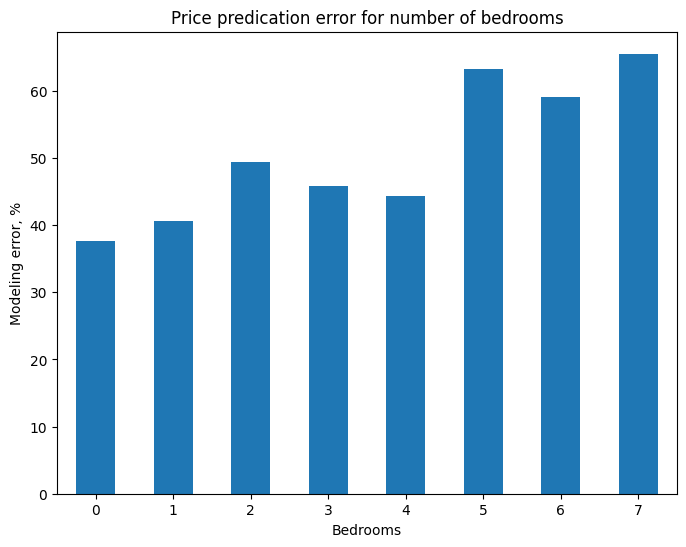

In [31]:
plt.figure(figsize=(8, 6))
df_error.groupby('bedrooms')['error_perc'].mean().plot.bar()
plt.xlabel('Bedrooms')
plt.ylabel('Modeling error, %')
plt.title('Price predication error for number of bedrooms')
plt.xticks(rotation=0);

From the above figure, we can say that the price prediction error increases when the number of bedrooms increases to 5 or more.

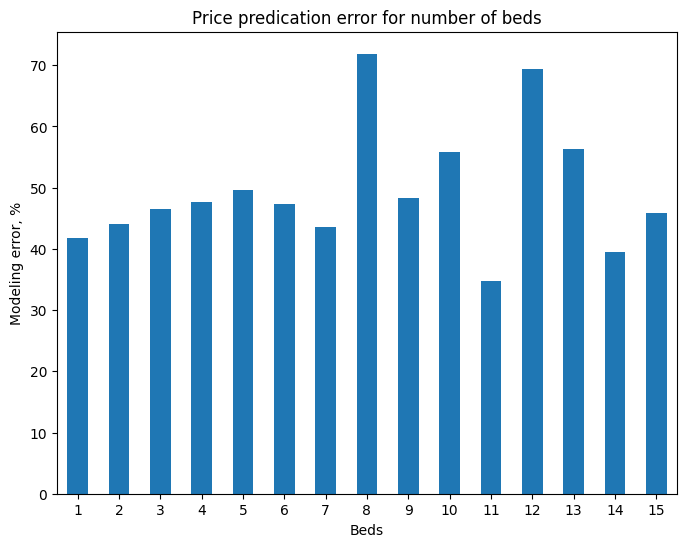

In [32]:
plt.figure(figsize=(8, 6))
df_error.groupby('beds')['error_perc'].mean().plot.bar()
plt.xlabel('Beds')
plt.ylabel('Modeling error, %')
plt.title('Price predication error for number of beds')
plt.xticks(rotation=0);

In [33]:
print('Value count for different number of beds:')
df_error['beds'].value_counts().sort_index()

Value count for different number of beds:


1      9029
2     11009
3      7507
4      4219
5      2043
6      1243
7       806
8       510
9       295
10      240
11      118
12      131
13       86
14       73
15       32
Name: beds, dtype: int64

Modeling error for the number of beds increases slowly up to 5-6 beds and then goes ups and down. We cannot draw a solide conclusion on how the error is impacted by number of beds but it should be noticed that the trend we are seeing for beds after 9 or more is not that significant as the number of listings in that range is relatively small.

The following plot shows error analysis at different zip codes (also the number of listing at each zipcode).

In [34]:
# find the number average modeling error in each zip code and create a df to plot it as well as the number of listings
zip_error = pd.concat([df_error.groupby('zipcode')['error_perc'].count().sort_values(ascending=False),
                       df_error.groupby('zipcode')['error_perc'].mean().sort_values(ascending=False)], axis=1 )
zip_error.columns = ['count', 'error_perc']
zip_error = zip_error.sort_values(by='error_perc', ascending=False)


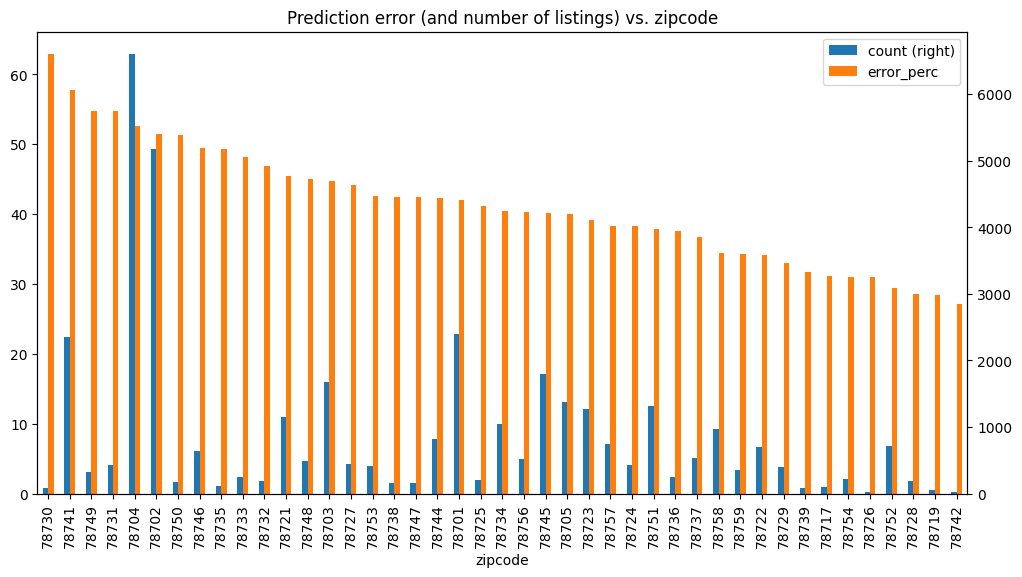

In [35]:
zip_error.plot.bar(secondary_y='count', figsize=(12, 6))
plt.title('Prediction error (and number of listings) vs. zipcode');

Zipcode analysis shows errors as high as 60% in some neighborhoods and as low as 30% in others. The number of listings in each neighborhood is ploted in this plot so that we know the error is calcualted based on how many observations. Caution should be practiced when interpreting the data from zip codes without too many listings.

At the end, let us see if we can find any meaningful correlation between our model error and the price of homes in each neighborhood.

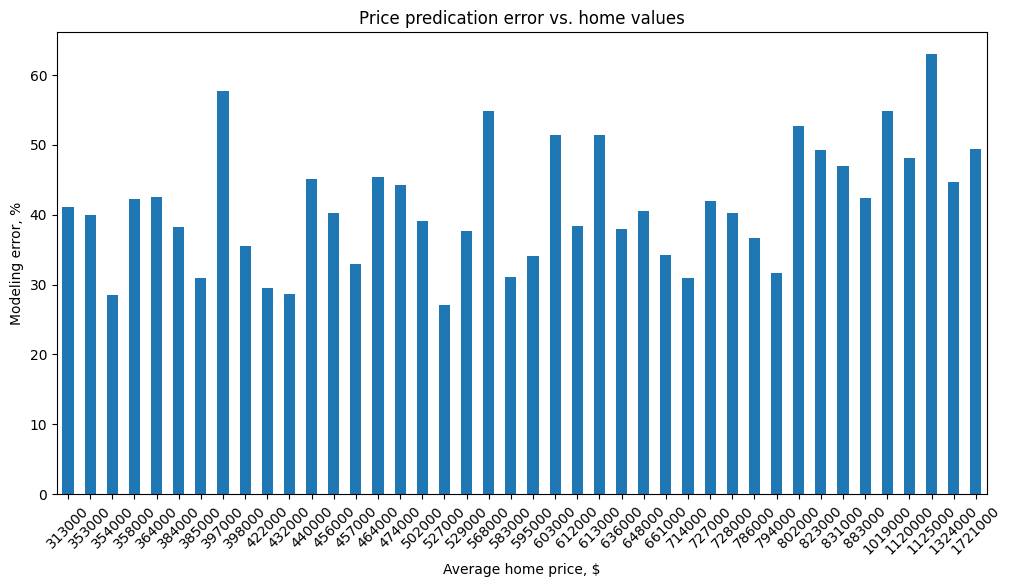

In [36]:
plt.figure(figsize=(12, 6))
df_error.groupby('home_price_aprx')['error_perc'].mean().sort_index(ascending=True).plot.bar()
plt.xlabel('Average home price, $')
plt.ylabel('Modeling error, %')
plt.title('Price predication error vs. home values')
plt.xticks(rotation=45);

The above plot does not show any meaningful correlation between the average home price and the airbnb home listing price error.

__Highlights:__
- Using polynomial features (quadratic terms) along with regularization has improved our linear regression model (R2 = 0.52). Both Ridge and LASSO have the same performance.

Error analysis:
- Prediction error shows a big jump for 5 bedrooms and more.
- Prediction error for listings that have pool is 10% higher than the ones without pool.
- Prediction error for listings with a super host is 10% lower than the listings without superhost.


## Neural Networks

In this section, we will try to use neural networks (NN) to build a model and estimate the listing price for airbnb houses. Since NN requires the data to be in numeric format (no categorical data), we will start our analysis by a model that only includes the numeric features so that we don't increase the dimensionality at the beginning.

In [4]:
X = df.drop(columns=['price', 'zipcode', 'time_quarter'])
y = df['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)

# scale the data
ss = StandardScaler()
Z_train = ss.fit_transform(X_train)
Z_test = ss.transform(X_test)

# build the sequential nn
nn_numeric = Sequential()
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu',
                     input_shape=(11,)))
# add a hidden layer
nn_numeric.add(Dense(256,
                     activation='relu'))
# add a hidden layer
nn_numeric.add(Dense(128,
                     activation='relu'))
# add output layer
nn_numeric.add(Dense(1,
                     activation=None))

# compile the model
nn_numeric.compile(loss='mse',
                   optimizer='adam')

# fit the model
es = EarlyStopping(patience = 5)
nn_numeric.fit(Z_train, y_train,
               epochs=200,
               batch_size=1024,
               callbacks=[es],
               validation_data=(Z_test, y_test))

# predict data
preds_train = nn_numeric.predict(Z_train)
preds_test = nn_numeric.predict(Z_test)

Epoch 1/200
30/30 [==============================] - 2s 20ms/step - loss: 110573.0469 - val_loss: 94252.5469
Epoch 2/200
30/30 [==============================] - 0s 14ms/step - loss: 55976.0117 - val_loss: 37278.4609
Epoch 3/200
30/30 [==============================] - 0s 15ms/step - loss: 31946.6816 - val_loss: 32131.3477
Epoch 4/200
30/30 [==============================] - 0s 15ms/step - loss: 30500.9238 - val_loss: 31534.5156
Epoch 5/200
30/30 [==============================] - 0s 14ms/step - loss: 29995.4277 - val_loss: 31084.5918
Epoch 6/200
30/30 [==============================] - 0s 14ms/step - loss: 29688.6699 - val_loss: 30849.5566
Epoch 7/200
30/30 [==============================] - 0s 14ms/step - loss: 29504.4297 - val_loss: 30691.1875
Epoch 8/200
30/30 [==============================] - 0s 15ms/step - loss: 29365.6973 - val_loss: 30583.7246
Epoch 9/200
30/30 [==============================] - 0s 14ms/step - loss: 29288.7656 - val_loss: 30506.2949
Epoch 10/200
30/30 [=======

In [5]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

Train data R2 = 0.5664
Train data MAE ($) = 94
Test data R2 = 0.5215
Test data MAE ($) = 98


In [ ]:



# gridsearch object
gs_lasso_poly_pipeline = GridSearchCV(lasso_poly_pipeline,
                                     param_grid={'lasso__alpha': np.logspace(-1, 1, 25)},
                                      verbose = 3,
                                      cv =3,
                                      n_jobs=-1
                                     )

# fit the model
gs_lasso_poly_pipeline.fit(X_train, y_train)

# predict data
preds_train = gs_lasso_poly_pipeline.predict(X_train)
preds_test = gs_lasso_poly_pipeline.predict(X_test)

# best alpha
print(gs_lasso_poly_pipeline.best_params_)

## XGBoost regressor

In this section, we will try to model the listing price using XGBoost. First, define the object columns as categories. and then create the object and run it.

In [20]:
df_xgb = df.copy()
# convert the type into category
df_xgb[['zipcode', 'time_quarter']] = df_xgb[['zipcode', 'time_quarter']].astype('category')

X = df_xgb.drop(columns=['price'])
y = df_xgb['price']
# train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state=42,
                                                    test_size=0.2)


# create the xgb instance
xgb_reg = xgb.XGBRegressor(enable_categorical=True)

param_space = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.2, 0.4, 0.6, 0.8],
    'max_depth': [5, 8, 10], # this has significant effects on R2
    'subsample': [0.5, 0.9, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'reg_alpha': [ 0.001, 0.01, 0.1, 1],
    'gamma': [0.1, 1, 3],
    'eta': [0.2, 0.5],
    'min_child_weight': [5, 7]

}
bayes_xgb_reg = BayesSearchCV(xgb_reg,
                         param_space,
                         cv=5,
                         verbose=0,
                         n_iter=50,
                         scoring='neg_mean_absolute_error',
                         random_state=42)
bayes_xgb_reg.fit(X_train, y_train)


# predict data
preds_train = bayes_xgb_reg.predict(X_train)
preds_test = bayes_xgb_reg.predict(X_test)

# parameters for the best estimator
print('=============')
print(bayes_xgb_reg.best_params_)
print(bayes_xgb_reg.best_score_)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.10/dist

OrderedDict([('colsample_bytree', 1.0), ('eta', 0.4817928782187996), ('gamma', 0.1), ('learning_rate', 0.2), ('max_depth', 10), ('min_child_weight', 7), ('n_estimators', 150), ('reg_alpha', 1.0), ('subsample', 1.0)])
-74.93063795104595


In [ ]:
print(f'Train data R2 = {round(r2_score(y_train, preds_train), 4)}')
print(f'Train data MAE ($) = {int(mean_absolute_error(y_train, preds_train))}')
print(f'Test data R2 = {round(r2_score(y_test, preds_test), 4)}')
print(f'Test data MAE ($) = {int(mean_absolute_error(y_test, preds_test))}')

As we can see from the results, we have been able to get a R2 score of 0.71 with XGBoost. The tree based algorithms are prone to overfitting and in order to control it, we have tried different hyperparameter tunings. `BayesSearchCV` was used to exhaust all the possible hyperparameter tunining options without increasing the runtime drastically.

__Highlights:__
- XGBoost gives us a test R2 of 0.71 after trying different hyperparameter tuning approaches.

In [ ]:
df_xgb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37341 entries, 0 to 37340
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   bedrooms              37341 non-null  int64   
 1   beds                  37341 non-null  int64   
 2   bath                  37341 non-null  float64 
 3   zipcode               37341 non-null  category
 4   host_is_superhost     37341 non-null  int64   
 5   review_scores_rating  37341 non-null  float64 
 6   time_quarter          37341 non-null  category
 7   has_pool              37341 non-null  int64   
 8   is_petfriendly        37341 non-null  int64   
 9   has_workspace         37341 non-null  int64   
 10  has_freeparking       37341 non-null  int64   
 11  has_gym               37341 non-null  int64   
 12  home_price_aprx       37341 non-null  int64   
 13  price                 37341 non-null  float64 
dtypes: category(2), float64(3), int64(9)
memory usage: 3.5


the idea of changing the range for price variables to get smaller range

error is higher for large prices, maybe do a log transform- no
considerings listings less than 500 doesnt help either
if we do polynomial, how to reduce the number of features (search and read, look at salaar) do degree 2, 3 polynomial

In [ ]:
# get the price of the house based on zipcode and the number of bedrooms from zillow (maybe averate 2020-2022end) https://www.zillow.com/research/data/
# find the average size of the house based on the number of bedrooms or so?
# Use DBSCAN to find outliers, then analyze those outliers and make decisions based on your audience and scope of the work you are doing
# find the outliers in box plot of the price, make decision based on scope
# what could be done when error for a specific value in feature is high, like have pool?
# can we remove some of the zips because of not having enough information?

In [ ]:
# do a model transformation like log at the end to see if it helps getting a better model for outliers
# do a bit of research to see how we should handle outliers-or consider a case where we focus on a more reasonable price range.
# do error analysis for linear regression comprehensive like plot error vs. other factors as hue
# is correlation between error and other factors
# should I do test train for each model?
# dimensionality reduction tests
# regularization for linear models
# functions if needed, like scaling and traintest
# something other than gridsearch
# error analysis in each of the models


- pipeline with ss and one hot encoder
- we can do polynomial features and regularization
- How to pick important features (see Salaar's notebook) or maybe PCA
- for tree based modela,  we can use PCA to select best features and then use that for a tree based regressor.